# <center> Рубежный контроль №2
## <center> "Технологии использования и оценки моделей машинного обучения"

<center> Вариант 9

   ### Задание:
   
Задача 1. Классификация текстов на основе методов наивного Байеса.

    Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

    Необходимо сформировать признаки на основе CountVectorizer или TfidfVectorizer.

    В качестве классификаторов необходимо использовать два классификатора, не относящихся к наивным Байесовским методам (например, LogisticRegression, LinearSVC), а также Multinomial Naive Bayes (MNB), Complement Naive Bayes (CNB), Bernoulli Naive Bayes.

    Для каждого метода необходимо оценить качество классификации с помощью хотя бы одной метрики качества классификации например, Accuracy).

    Сделате выводы о том, какой классификатор осуществляет более качественную классификацию на Вашем наборе данных.

Задача 2. Кластеризация данных

    Кластеризуйте данные с помощью двух алгоритмов кластеризации: K-Means (k-means++) 	Birch

Сравните качество кластеризации с помощью следующих метрик качества кластеризации (если это возможно для Вашего набора данных):

    Adjusted Rand index
    Adjusted Mutual Information
    Homogeneity, completeness, V-measure
    Коэффициент силуэта

Сделате выводы о том, какой алгоритм осуществляет более качественную кластеризацию на Вашем наборе данных.

In [17]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [18]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

# Задача 1. Классификация текстов на основе методов наивного Байеса

### Использованный набор данных

Для лабораторной работы будем использовать набор данных об [отзывах на Амазон](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set)

Колонки:

 - `text` - текст отзыва
 - `value` - значение отзыва
 - `Unnamed: 2` - неизвестный параметр 1
 - `Unnamed: 3` - неизвестный параметр 2
 - `Unnamed: 4` - неизвестный параметр 3
 - `Unnamed: 5` - неизвестный параметр 4

In [33]:
# Таблица данных
data = pd.read_csv("../Dataset/amazon_cells_labelled.txt",  delimiter= '\t',  header= None,  names= ['text',  'value']) 
data.head()

,text,value
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [34]:
# Размер набора данных
data.shape

(1000, 2)

In [35]:
# Типы данных в колонках
data.dtypes

text     object
value     int64
dtype: object

**Проверка на наличие пропущенных значений**

In [36]:
data.isnull().sum()

text     0
value    0
dtype: int64

## 1. Векторизация

Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки

In [37]:
vocab_list = data['text'].tolist()
vocab_list[1:10]

['Good case, Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.',
 'I have to jiggle the plug to get it to line up right to get decent volume.',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.',
 'If you are Razr owner...you must have this!',
 'Needless to say, I wasted my money.',
 'What a waste of money and time!.']

### 1.1. Создание векторизатора:

In [38]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 1847


In [39]:
for i in list(corpusVocab)[1:10]:
    print('{}={}'.format(i, corpusVocab[i]))

there=1609
is=854
no=1074
way=1766
for=653
me=993
to=1640
plug=1212
it=857


Сначала в словаре идут все номера, которые попадались в спам-сообщениях:

In [40]:
vocabVect.get_feature_names()[10:20]

['2005', '2160', '24', '2mp', '325', '350', '375', '3o', '42', '44']

После них уже идут все обнаруженные слова:

In [43]:
vocabVect.get_feature_names()[1000:1010]

['memory',
 'mention',
 'mentioned',
 'menus',
 'mere',
 'mess',
 'message',
 'messages',
 'messaging',
 'messes']

### 1.2. Использование N-грам

Создадим словарь, содержащий словосочетания, состоящие из 1, 2, 3 слов

In [44]:
ncv = CountVectorizer(ngram_range=(1,3))
ngram_features = ncv.fit_transform(vocab_list)
print('Обнаружено словосочетаний:',len(ncv.get_feature_names()))

Обнаружено словосочетаний: 15088


In [45]:
print ("Примеры словосочетаний:")
print(ncv.get_feature_names()[1000:1010],'\n')
print(ncv.get_feature_names()[13000:13010])

Примеры словосочетаний:
['any damage', 'any from', 'any from that', 'any helpful', 'any helpful support', 'any kind', 'any kind of', 'any large', 'any large problems', 'any longer'] 

['to do anything', 'to do everything', 'to do hard', 'to do voice', 'to download', 'to download the', 'to everyone', 'to exchange', 'to exchange bad', 'to find']


## 2. Решение задачи классификации

In [46]:
def VectorizeAndClassify(vectorizers_list, classifiers_list):
    for v in vectorizers_list:
        for c in classifiers_list:
            pipeline1 = Pipeline([("vectorizer", v), ("classifier", c)])
            score = cross_val_score(pipeline1, data['text'], data['value'], scoring='accuracy', cv=3).mean()
            print('Векторизация - {}'.format(v))
            print('Модель для классификации - {}'.format(c))
            print('Accuracy = {}'.format(score))
            print('===========================')

In [47]:
vectorizers_list = [CountVectorizer(vocabulary = corpusVocab), TfidfVectorizer(vocabulary = corpusVocab)]
classifiers_list = [LogisticRegression(C=3.0), LinearSVC(), KNeighborsClassifier()]
VectorizeAndClassify(vectorizers_list, classifiers_list)

Векторизация - CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None,
                vocabulary={'10': 0, '100': 1, '11': 2, '12': 3, '13': 4,
                            '15': 5, '15g': 6, '18': 7, '20': 8, '2000': 9,
                            '2005': 10, '2160': 11, '24': 12, '2mp': 13,
                            '325': 14, '350': 15, '375': 16, '3o': 17, '42': 18,
                            '44': 19, '45': 20, '4s': 21, '50': 22, '5020': 23,
                            '510': 24, '5320': 25, '680': 26, '700w': 27,
                            '8125': 28, '8525': 29, ...})
Модель для классификации - LogisticRegression(C=3.0, class_weight=None,

Dсе модели имеют посредственные показатели качества в районе 0,8.

Лучшая точно была получения при использовании CountVectorizer с методом линеаризации SVC. Точность: 0.825.

## 3. Разделим выборку на обучающую и тестовую и проверим решение для лучшей модели

In [48]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(Y_test, Y_pred)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'],data['value'],test_size=0.05,random_state=1)

In [50]:
sentiment(CountVectorizer(), LinearSVC())

Метка 	 Accuracy
0 	 0.9
1 	 0.85


In [51]:
sentiment(CountVectorizer(ngram_range=(1,3)), LinearSVC())

Метка 	 Accuracy
0 	 0.9333333333333333
1 	 0.85


In [52]:
sentiment(CountVectorizer(ngram_range=(2,3)), LinearSVC())

Метка 	 Accuracy
0 	 0.8666666666666667
1 	 0.75


In [53]:
sentiment(CountVectorizer(ngram_range=(1,4)), LinearSVC())

Метка 	 Accuracy
0 	 0.9333333333333333
1 	 0.85


In [54]:
sentiment(CountVectorizer(ngram_range=(2,4)), LinearSVC())

Метка 	 Accuracy
0 	 0.8
1 	 0.95


Лучше всего себя показала комбинация векторизатора со словосочетаниями (1, 3) и (1, 4). Также видно, что при удалении из N-грам словосочетаний длиной 1 точность падает.

Скорее всего это связано с тем, что оттенок отзыва лучше отражается словосочетанием, либо отдельными. но сильно выразительными словами

## 4. Решение задачи классификации текстов с использованием Байесовских методов

Оценим распределение целевого признака

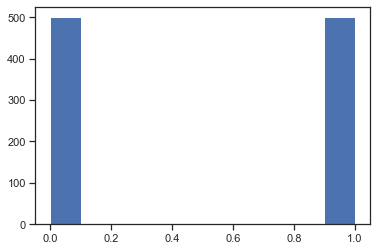

In [55]:
plt.hist(data['value'])
plt.show()

Положительных и отрицательных отзывов поровну, поэтому будем MultinomialNB и ComplementNB должны работать примерно одинаково. Проверим это и сравним их

In [63]:
sentiment(CountVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 0.9
1 	 0.85


In [64]:
sentiment(TfidfVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 0.8666666666666667
1 	 0.85


In [65]:
sentiment(CountVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.9
1 	 0.85


In [66]:
sentiment(TfidfVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.9
1 	 0.85


Точность получилась примерно одинаковой, как и ожидалось

Точность для меток 0 и 1 не изменились по сравнению с CountVectorizer с методом опорных векторов. Наивный Байесовский метод показал настолько же точным, но не дал более высокого результата.

Попробуем другие методы:

In [69]:
# Классификация с использованием логистической регрессии
sentiment(CountVectorizer(), LogisticRegression(C=5.0))

Метка 	 Accuracy
0 	 0.9
1 	 0.85


In [68]:
sentiment(TfidfVectorizer(), LogisticRegression(C=5.0))

Метка 	 Accuracy
0 	 0.9333333333333333
1 	 0.85


In [62]:
sentiment(CountVectorizer(binary=True), BernoulliNB())

Метка 	 Accuracy
0 	 0.9
1 	 0.8


Методы классификации текстов, основанные на Наивном Байесе работают однозначно не хуже чем логистическая регрессия

Он может себя хорошо показать, когда признаком текста будут являться целые числа или даже действительные